
ANALYSE DES RÉGIMES DE COUPLAGE
Température: 0.500000 eV
Beta (1/kT): 2.00 eV^-1
Points de biais: 15


Calcul pour gamma = 0.01 (weak1)...
  5/15 points calculés...
  10/15 points calculés...
  15/15 points calculés...
  Temps total pour gamma=0.01: 37.58s

Calcul pour gamma = 0.02 (weak2)...
  5/15 points calculés...
  10/15 points calculés...
  15/15 points calculés...
  Temps total pour gamma=0.02: 50.20s

Calcul pour gamma = 0.05 (weak3)...
  5/15 points calculés...
  10/15 points calculés...
  15/15 points calculés...
  Temps total pour gamma=0.05: 53.52s

Calcul pour gamma = 0.1 (weak4)...
  5/15 points calculés...
  10/15 points calculés...
  15/15 points calculés...
  Temps total pour gamma=0.1: 53.58s

Calcul pour gamma = 0.2 (weak5)...
  5/15 points calculés...
  10/15 points calculés...
  15/15 points calculés...
  Temps total pour gamma=0.2: 47.24s

CRÉATION DES TRACÉS INDIVIDUELS
  Figure sauvegardée: heom_gamma_0.010_weak1.png
  Figure sauvegardée: heom_gamma_0.020_weak2

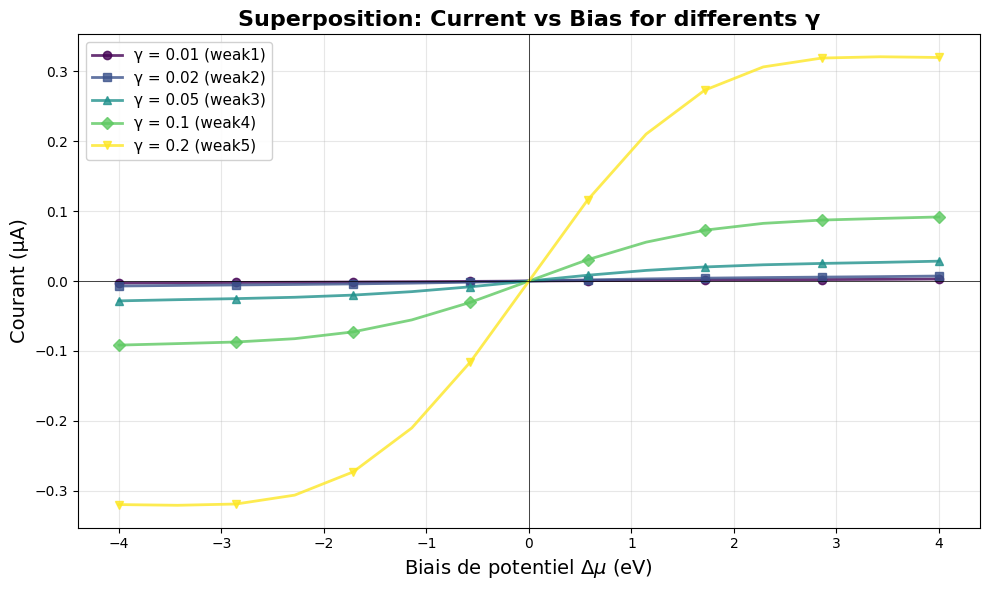

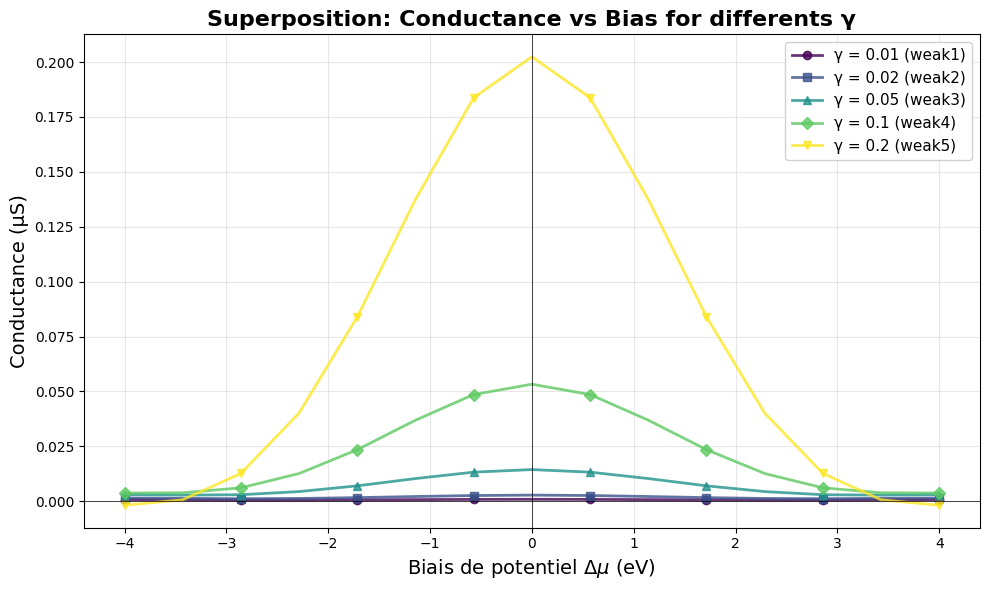

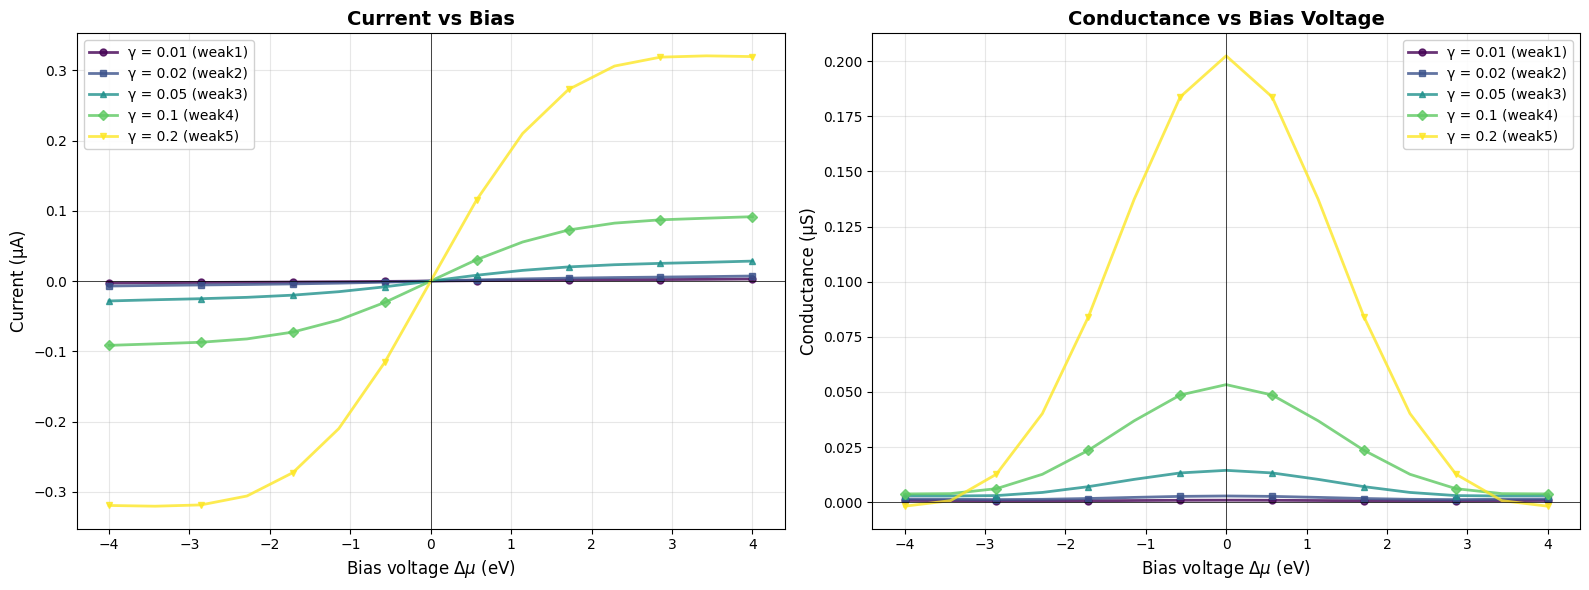


RÉSUMÉ DES RÉSULTATS

weak1 (γ=0.01):
  Courant max: 0.0029 µA
  Conductance max: 0.0009 µS
  Courant à θ=0: 0.0000 µA

weak2 (γ=0.02):
  Courant max: 0.0071 µA
  Conductance max: 0.0028 µS
  Courant à θ=0: 0.0000 µA

weak3 (γ=0.05):
  Courant max: 0.0284 µA
  Conductance max: 0.0144 µS
  Courant à θ=0: 0.0000 µA

weak4 (γ=0.1):
  Courant max: 0.0916 µA
  Conductance max: 0.0533 µS
  Courant à θ=0: -0.0000 µA

weak5 (γ=0.2):
  Courant max: 0.3206 µA
  Conductance max: 0.2024 µS
  Courant à θ=0: 0.0000 µA

INTERPRÉTATION PHYSIQUE

Couplage TRÈS FAIBLE (γ=0.01):
  - Régime tunnel perturbatif
  - Courant très faible
  - Conductance limitée par la barrière tunnel

Couplage FAIBLE (γ=0.02):
  - Début des effets de cohérence quantique
  - Augmentation linéaire du courant avec γ

Couplage MOYEN-FAIBLE (γ=0.05):
  - Transition vers le régime non-perturbatif
  - Émergence d'effets de corrélation

Couplage MOYEN (γ=0.1):
  - Régime de couplage intermédiaire
  - Équilibre entre tunnel et cohéren

In [6]:
import contextlib
import time
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.core.environment import LorentzianEnvironment
from qutip.solver.heom import HEOMSolver

@contextlib.contextmanager
def timer(label):
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start:.2f}s")

def state_current(ado_state, bath_tag):
    """Calcule le courant à partir de l'état ADO"""
    level_1_aux = [
        (ado_state.extract(label), ado_state.exps(label)[0])
        for label in ado_state.filter(level=1, tags=[bath_tag])
    ]
    
    def exp_sign(exp):
        return 1 if exp.type == exp.types["+"] else -1
    
    def exp_op(exp):
        return exp.Q if exp.type == exp.types["+"] else exp.Q.dag()
    
    return -1.0j * sum(
        exp_sign(exp) * (exp_op(exp) * aux).tr() 
        for aux, exp in level_1_aux
    )

# Options du solveur
options = {
    "nsteps": 1500,
    "store_states": True,
    "store_ados": True,
    "rtol": 1e-12,
    "atol": 1e-12,
    "method": "vern9",
    "progress_bar": "enhanced",
}

# Paramètres du système
class SystemParameters:
    def __init__(self, e1=-5, U=10, Nbos=2):
        self.e1 = e1
        self.U = U
        self.Nbos = Nbos
        
        # Opérateurs
        d_up = tensor(destroy(2), qeye(self.Nbos))
        sz = sigmaz()
        d_dn = tensor(-sz, destroy(2))
        
        # Hamiltonien
        self.H = (
            self.e1 * (d_up.dag() * d_up + d_dn.dag() * d_dn) +
            self.U * (d_up.dag() * d_up * d_dn.dag() * d_dn)
        )
        self.Q1 = d_up
        self.Q2 = d_dn
        self.Q = d_up + d_dn

# Paramètres du bain
class LorentzianBathParameters:
    def __init__(self, lead, Q, gamma=2.0, W=2, T_eV=0.5, theta=2):
        self.lead = lead
        self.Q = Q
        self.gamma = gamma
        self.W = W
        self.T = T_eV
        self.theta = theta
        self.beta = 1.0 / self.T
        
        if self.lead == "L":
            self.mu = self.theta / 2.0
        else:
            self.mu = -self.theta / 2.0

def steady_state_current(sys_p, bath_L, bath_R, theta, gamma, Nk=6, Nc=2, Nbos=2):
    """Calcule le courant à l'état stationnaire"""
    sys_p = SystemParameters(Nbos=Nbos)
    
    # Mise à jour des paramètres de bain avec gamma
    bath_L_updated = LorentzianBathParameters(
        lead="L", Q=sys_p.Q1, gamma=gamma, theta=theta
    )
    bath_R_updated = LorentzianBathParameters(
        lead="R", Q=sys_p.Q2, gamma=gamma, theta=theta
    )
    
    # Environnements
    envL = LorentzianEnvironment(
        bath_L_updated.T, bath_L_updated.mu, 
        bath_L_updated.gamma, bath_L_updated.W
    )
    envR = LorentzianEnvironment(
        bath_R_updated.T, bath_R_updated.mu,
        bath_R_updated.gamma, bath_R_updated.W
    )
    
    # Approximation de Matsubara
    bathL = envL.approx_by_matsubara(Nk, tag="L")
    bathR = envR.approx_by_matsubara(Nk, tag="R")
    
    # État initial
    dims = [[2, 2], [2, 2]]
    rho_0 = Qobj(np.diag([1, 0, 0, 0]), dims=dims)
    
    # Solveur HEOM
    solver = HEOMSolver(
        sys_p.H,
        [(bathL, sys_p.Q), (bathR, sys_p.Q)],
        max_depth=Nc,
        options=options,
    )
    
    # État stationnaire
    rho_ss, ado_ss = solver.steady_state()
    current = state_current(ado_ss, bath_tag="R")
    
    # Conversion en µA
    return np.real(2.434e-4 * 1e6 * current)

# ============ ANALYSE MULTI-GAMMA ============

# Valeurs de gamma à explorer (corrigé pour éviter les doublons)
gamma_values = {
    'weak1': 0.01,
    'weak2': 0.02,
    'weak3': 0.05,
    'weak4': 0.1,
    'weak5': 0.2
}

# Paramètres de simulation
Nk = 6
Nc = 2
Nbos = 2
thetas = np.linspace(-4, 4, 15)

sys_p = SystemParameters(Nbos=Nbos)
bath_L = LorentzianBathParameters(lead="L", Q=sys_p.Q1)
bath_R = LorentzianBathParameters(lead="R", Q=sys_p.Q2)

# Stockage des résultats
results = {}

print("\n" + "="*60)
print("ANALYSE DES RÉGIMES DE COUPLAGE")
print("="*60)
print(f"Température: {bath_L.T:.6f} eV")
print(f"Beta (1/kT): {bath_L.beta:.2f} eV^-1")
print(f"Points de biais: {len(thetas)}")
print("="*60 + "\n")

# ============ CALCUL POUR CHAQUE GAMMA ============
for label, gamma in gamma_values.items():
    print(f"\nCalcul pour gamma = {gamma} ({label})...")
    currents = []
    
    with timer(f"  Temps total pour gamma={gamma}"):
        for i, theta in enumerate(thetas):
            current = steady_state_current(
                sys_p, bath_L, bath_R, theta, 
                gamma=gamma, Nk=Nk, Nc=Nc, Nbos=Nbos
            )
            currents.append(current)
            
            if (i + 1) % 5 == 0:
                print(f"  {i+1}/{len(thetas)} points calculés...")
    
    results[label] = {
        'currents': np.array(currents),
        'conductance': np.gradient(currents, thetas),
        'gamma': gamma
    }

# ============ TRACÉS INDIVIDUELS POUR CHAQUE GAMMA ============
print("\n" + "="*60)
print("CRÉATION DES TRACÉS INDIVIDUELS")
print("="*60)

for label, data in results.items():
    gamma = data['gamma']
    
    # Création de la figure individuelle
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Courbe de courant
    ax1.plot(thetas, data['currents'], 'b-', linewidth=2.5, marker='o', markersize=5)
    ax1.set_xlabel(r'Bias voltage $\Delta\mu$ (eV)', fontsize=12)
    ax1.set_ylabel(r'Current (µA)', fontsize=12)
    ax1.set_title(f'Courant vs Biais - γ = {gamma} ({label})', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax1.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    
    # Courbe de conductance
    ax2.plot(thetas, data['conductance'], 'r-', linewidth=2.5, marker='s', markersize=5)
    ax2.set_xlabel(r'Bias voltage $\Delta\mu$ (eV)', fontsize=12)
    ax2.set_ylabel(r'Conductance (µS)', fontsize=12)
    ax2.set_title(f'Conductance vs Biais - γ = {gamma} ({label})', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax2.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    
    # Sauvegarde de la figure individuelle
    filename = f'heom_gamma_{gamma:.3f}_{label.replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Ferme la figure pour libérer la mémoire
    print(f"  Figure sauvegardée: {filename}")

# ============ SUPERPOSITION POUR TOUS LES GAMMA ============
print("\n" + "="*60)
print("CRÉATION DE LA SUPERPOSITION")
print("="*60)

# 1. Superposition des courants
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(results)))
markers = ['o', 's', '^', 'D', 'v']

for (label, data), color, marker in zip(results.items(), colors, markers):
    gamma = data['gamma']
    ax1.plot(thetas, data['currents'], 
             color=color, linewidth=2, 
             marker=marker, markersize=6, markevery=2,
             label=f'γ = {gamma} ({label})',
             alpha=0.8)

ax1.set_xlabel(r'Biais de potentiel $\Delta\mu$ (eV)', fontsize=14)
ax1.set_ylabel(r'Courant (µA)', fontsize=14)
ax1.set_title('Superposition: Current vs Bias for differents γ', 
             fontsize=16, fontweight='bold')
ax1.legend(loc='best', fontsize=11, framealpha=0.9)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax1.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('heom_superposition_courants.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig1)

# 2. Superposition des conductances
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))

for (label, data), color, marker in zip(results.items(), colors, markers):
    gamma = data['gamma']
    ax2.plot(thetas, data['conductance'], 
             color=color, linewidth=2, 
             marker=marker, markersize=6, markevery=2,
             label=f'γ = {gamma} ({label})',
             alpha=0.8)

ax2.set_xlabel(r'Biais de potentiel $\Delta\mu$ (eV)', fontsize=14)
ax2.set_ylabel(r'Conductance (µS)', fontsize=14)
ax2.set_title('Superposition: Conductance vs Bias for differents γ', 
             fontsize=16, fontweight='bold')
ax2.legend(loc='best', fontsize=11, framealpha=0.9)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax2.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('heom_superposition_conductances.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig2)

# 3. Figure combinée (courant et conductance côte à côte)
fig3, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 6))

for (label, data), color, marker in zip(results.items(), colors, markers):
    gamma = data['gamma']
    
    # Courant
    ax3.plot(thetas, data['currents'], 
             color=color, linewidth=2, 
             marker=marker, markersize=5, markevery=2,
             label=f'γ = {gamma} ({label})',
             alpha=0.8)
    
    # Conductance
    ax4.plot(thetas, data['conductance'], 
             color=color, linewidth=2, 
             marker=marker, markersize=5, markevery=2,
             label=f'γ = {gamma} ({label})',
             alpha=0.8)

ax3.set_xlabel(r'Bias voltage $\Delta\mu$ (eV)', fontsize=12)
ax3.set_ylabel(r'Current (µA)', fontsize=12)
ax3.set_title('Current vs Bias', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=10, framealpha=0.9)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax3.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

ax4.set_xlabel(r'Bias voltage $\Delta\mu$ (eV)', fontsize=12)
ax4.set_ylabel(r'Conductance (µS)', fontsize=12)
ax4.set_title('Conductance vs Bias Voltage', fontsize=14, fontweight='bold')
ax4.legend(loc='best', fontsize=10, framealpha=0.9)
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax4.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('heom_superposition_complete.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig3)

# ============ ANALYSE DES RÉSULTATS ============

print("\n" + "="*60)
print("RÉSUMÉ DES RÉSULTATS")
print("="*60)

for label, data in results.items():
    max_current = np.max(np.abs(data['currents']))
    max_conductance = np.max(data['conductance'])
    
    print(f"\n{label} (γ={data['gamma']}):")
    print(f"  Courant max: {max_current:.4f} µA")
    print(f"  Conductance max: {max_conductance:.4f} µS")
    print(f"  Courant à θ=0: {data['currents'][len(thetas)//2]:.4f} µA")

print("\n" + "="*60)
print("INTERPRÉTATION PHYSIQUE")
print("="*60)
print("""
Couplage TRÈS FAIBLE (γ=0.01):
  - Régime tunnel perturbatif
  - Courant très faible
  - Conductance limitée par la barrière tunnel

Couplage FAIBLE (γ=0.02):
  - Début des effets de cohérence quantique
  - Augmentation linéaire du courant avec γ

Couplage MOYEN-FAIBLE (γ=0.05):
  - Transition vers le régime non-perturbatif
  - Émergence d'effets de corrélation

Couplage MOYEN (γ=0.1):
  - Régime de couplage intermédiaire
  - Équilibre entre tunnel et cohérence

Couplage MOYEN-FORT (γ=0.2):
  - Approche du régime de couplage fort
  - Effets de blocage de Coulomb modifiés
  - Conductance significative même à faible biais
""")

print("\n" + "="*60)
print("FICHIERS GÉNÉRÉS")
print("="*60)
print("Tracés individuels:")
for label in results.keys():
    gamma = results[label]['gamma']
    filename = f'heom_gamma_{gamma:.3f}_{label.replace(" ", "_")}.png'
    print(f"  - {filename}")

print("\nTracés de superposition:")
print("  - heom_superposition_courants.png")
print("  - heom_superposition_conductances.png")
print("  - heom_superposition_complete.png")

print("\n" + "="*60)
print("SIMULATION TERMINÉE AVEC SUCCÈS!")
print("="*60)